In [84]:
# install the required datsets and models 
!pip install --upgrade tensorflow
!mkdir data
!wget wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights  # Directly the weigths file are downloaded and uploaded in the data file

In [85]:
# import required libraries
import numpy as np
import pandas as pd
import cv2, os, glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Concatenate, Conv2D,
    Input, Lambda, LeakyReLU,
    MaxPool2D, UpSampling2D, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.utils import plot_model

In [86]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]


# Defining 3 anchor boxes for each grid
yolo_anchors = np.array([
    (10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
    (59, 119), (116, 90), (156, 198), (373, 326)],
    np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])


 
class_names = [
    'person', 'bicycle','car','motorbike','aeroplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench',
    'bird','cat','dog','horse','sheep','cow','elephant','bear','zebra',
    'giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
    'skis','snowboard','sports ball','kite','baseball bat','baseball glove',
    'skateboard','surfboard','tennis racket','bottle','wine glass','cup',
    'fork','knife','spoon','bowl','banana','apple','sandwich','orange',
    'broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa',
    'pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink',
    'refrigerator','book','clock','vase','scissors','teddy bear',
    'hair drier','toothbrush'
]


In [87]:
#Function to load weights from original Yolo trained model in Darknet
def load_darknet_weights(model, weights_file, tiny = False):
    wf = open(weights_file, 'rb') # reading weights file
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLOV3_LAYER_LIST
    # iterating through all layers define in above yolov3_layers_list
    for layer_name in layers:
        #if there is one layer darknet then there is many sub layers inside it's network
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [63]:
# Define function for calculating intersection over union which is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.
 #which help in the nms function.
def broadcast_iou(box_1, box_2):
    '''
    box_1: (..., (x1, y1, x2, y2))
    box_2: (N, (x1, y1, x2, y2))
    '''
    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape) # it will change the shape of box into new_shape given
    box_2 = tf.broadcast_to(box_2, new_shape)
    # in below code we are finding intersection box width and height through which we will find intersection area,and this we are finding all boxes 
    int_w = tf.maximum(tf.minimum(box_1[2], box_2[2]) - tf.maximum(box_1[ 0], box_2[ 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[3], box_2[3]) - tf.maximum(box_1[1], box_2[1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])  # this box_1_area contains all boxes area predicted in an image
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])  # this box2_area is our ground truth box area
    return int_area / (box_1_area + box_2_area - int_area)

In [88]:
# Freezing a layer is about controlling the way the weights are updated. When a layer is frozen, it means that the weights cannot be modified further.
def freeze_all(model, frozen = True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [89]:
# Function for drawing bounding box, class name and is a Helper, util, function that draws predictons on the image
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs # predicted outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    # iterate through each valid predictions
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)         # it will create a rectangle box around object.
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)  # help it displaying text of predicted class with objectness score*class_probabilities
    return img

In [90]:
# Function for transforming the images 
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

In [91]:
#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
#In this case, any loss Tensors passed to this Model must be able to be traced back to the model's Inputs. These losses become part of the model's topology and are tracked in get_config
class BatchNormalization(tf.keras.layers.BatchNormalization):                              

    def call(self, x, training = False):                                                    
        if training is None:
            traininig = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [68]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):                #Call this function to define a single Darknet convolutional layer
    if strides == 1:                                       # if stride is 1 then we apply 'same' padding
        padding = 'same'                                  # i.e which output same shape as input if we input = (416,416) then output will also be (416,416)
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)                 # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,                #Defining the Convolution layer
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

In [69]:
def DarknetResidual(x, filters):                                                #Call this function to define a single DarkNet Residual layer                                               
    prev = x                                                                    #Here parameter filters are the no of filters in convolution layer.
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

In [70]:
# this is our real Darknetblock function calling above 2 fucntions 
def DarknetBlock(x, filters, blocks):                                            # Call this function to define a single DarkNet Block  made of multiple Residual layers
    x = DarknetConv(x, filters, 3, strides=2)                                    # Here the parameter filters are the no of filters in each residual layer not in the convolutional layer.
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

In [71]:
#This is the main function that creates the whole DarkNet.The Darknet is open source neural network which is highly accurate for custom trained models.
# the below x_36,x_61 and x are outputs which we will use in next function for upsampling and detecting objects.
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [72]:
#Call this function to define the Yolo Conv layer.
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            x = DarknetConv(x, filters, 1)
            # upsampling of a layer
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])                                      # concatenation of skip connection result and last output result  
        else:
            x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [73]:
# function is yolov3 output i.e last 3 convolution layer which will predict anchors 
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])                    # this is an input shape excluded with batch size.
        x = DarknetConv(x, filters * 2, 3)                    # Darkconv is a fn implemented above which is internally calling
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)))(x)  # x is reshaped into (None, grid_size, grid_size, anchors, (x,y,w,h,objectness score,..classes))
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

In [74]:
# Call this function to get bounding boxes from network predictions
def yolo_boxes(pred, anchors, classes):
    '''pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))'''
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, objectness, class_probs, pred_box

In [75]:
# nms function will suppressed those bounding box result which is not effective on the basis of yolo_maximum_threshold(IOU) and objectness score
def yolo_nms(outputs, anchors, masks, classes):
    '''boxes, conf, type'''
    b, c, t = [], [], [] 
    # iterating through each outputs predicted by model
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores,
            (tf.shape(scores)[0], -1, tf.shape(scores)[-1])
        ),
        max_output_size_per_class=100,
        max_total_size = 100,
        iou_threshold = 0.5,         # threshold for filtering the boxes
        score_threshold = 0.5         # threshold for objectness score below which we ignore that bounding box
    )
    return boxes, scores, classes, valid_detections

In [76]:
# this is main function for our backbone or darknet archietcture which calls above implemented functions
def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)   # backbone networks 3 outputs w.r.t to each grid size till here darknet network
    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)
    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)
    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)
    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)
    # after combining boxes from various scales we have too large so to remove invalid boxes we use non_maximum_suppression 
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))
    return Model(inputs, outputs, name='yolov3')

In [77]:
yolo = YoloV3(classes = 80)
yolo.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input_21[0][0]                   
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, None, None, 5 11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, None, None, 2 2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

In [78]:
load_darknet_weights(yolo, './data/yolov3.weights', False)

In [79]:
def predict(image_file, visualize = True, figsize = (16, 16)):
    img = tf.image.decode_image(open(image_file, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)
    img = transform_images(img, 416)
    boxes, scores, classes, nums = yolo.predict(img)
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    if visualize:
        fig, axes = plt.subplots(figsize = figsize)
        plt.imshow(img)
        plt.show()
    return boxes, scores, classes, nums

In [80]:
image_file =['/content/leon-Oalh2MojUuk-unsplash.jpg','/content/mudassir-ali-DvreeyPXQww-unsplash.jpg','/content/oscar-sutton-yihlaRCCvd4-unsplash.jpg']
len(image_file)

3

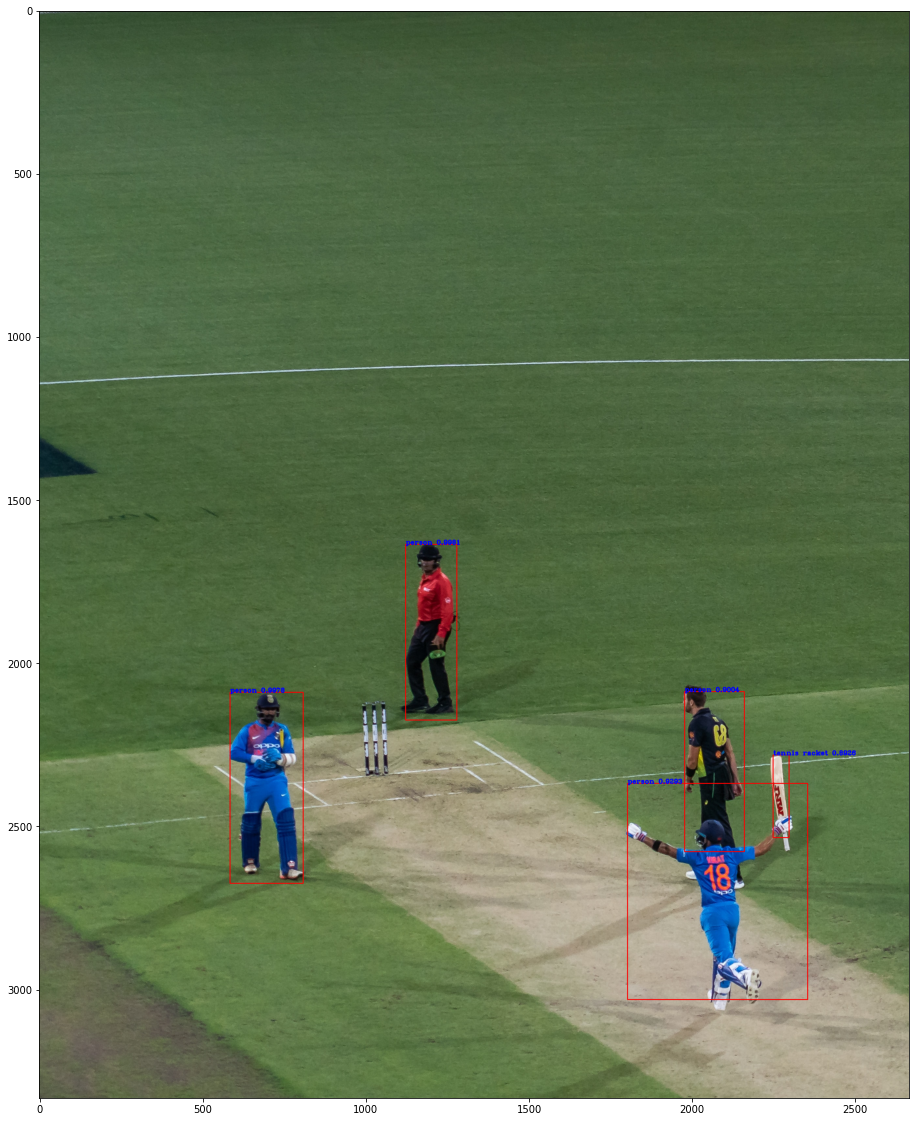

In [81]:
boxes, scores, classes, nums= predict(image_file[1], figsize = (20, 20))

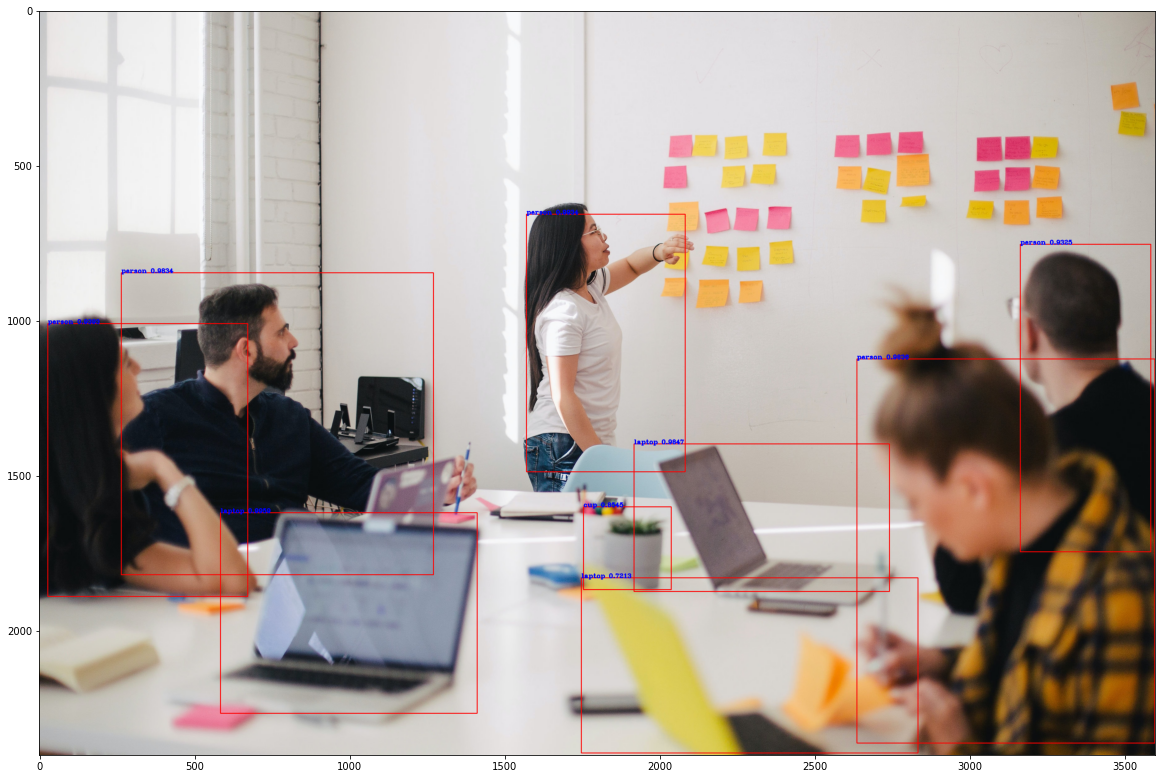

In [82]:
boxes, scores, classes, nums= predict(image_file[0], figsize = (20, 20))

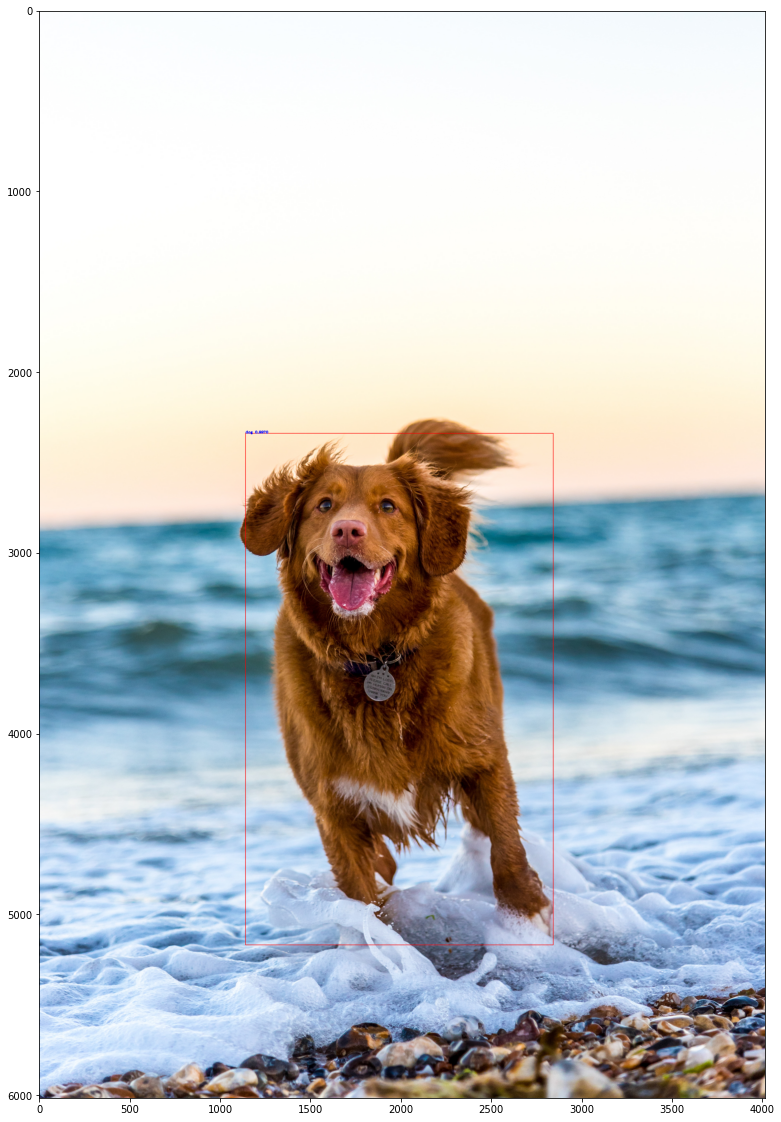

In [83]:
boxes, scores, classes, nums= predict(image_file[2], figsize = (20, 20))